In [7]:
!pip install tensorflow

  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.1.1-py2.py3-none-any.whl (146 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=84c65974a34428ca939a98bcd83b1fbe0be92d7b23cdab297b4c8a4d8ee6293e
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached protobuf-3.19.1-cp38-cp38-win_amd64.whl (895 kB)
  Using cached tensorflow_estimator-2.7.0-py2.py3-none-any.whl (463 kB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached grpcio-1.41.1-cp38-cp38-win_amd64.whl (3.2 MB)


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [2]:
data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

data.dropna(inplace=True)
data.drop(['Timestamp'],axis=1,inplace=True)

In [3]:
data

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
...,...,...,...,...,...,...,...
4857372,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


<AxesSubplot:>

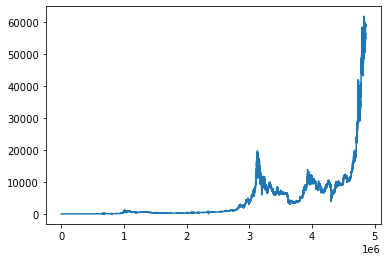

In [4]:
data['Close'].plot()

<AxesSubplot:>

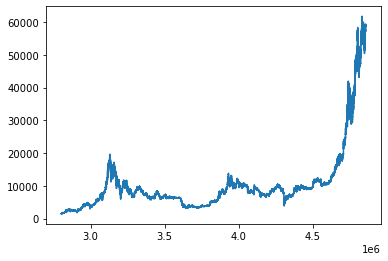

In [5]:
data.tail(2000000)['Close'].plot()

<AxesSubplot:>

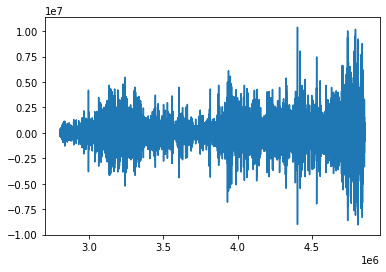

In [6]:
data.diff().tail(2000000)['Volume_(Currency)'].plot()

<AxesSubplot:>

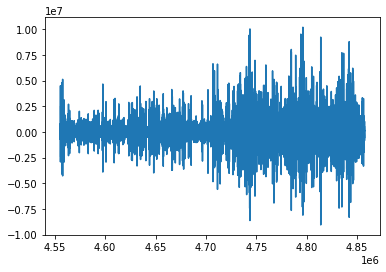

In [7]:
data.diff().tail(300000)['Volume_(Currency)'].plot()

<AxesSubplot:>

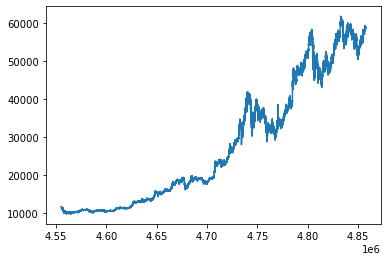

In [8]:
data.tail(300000)['Close'].plot()

<AxesSubplot:>

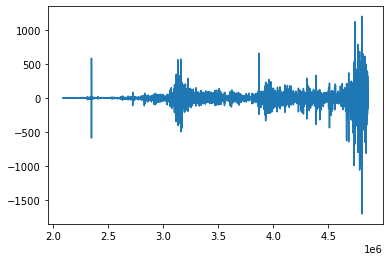

In [9]:
data.diff().tail(2500000)['Close'].plot()

In [10]:
t = data.reset_index()[['Volume_(Currency)', 'Close']]
t

,Volume_(Currency),Close
0,2.000000,4.39
1,210.720000,4.39
2,171.380338,4.57
3,41.220000,4.58
4,6.879160,4.58
...,...,...
3613764,81259.372187,58686.00
3613765,428158.146640,58685.81
3613766,100117.070370,58723.84
3613767,42332.958633,58760.59


In [11]:
t.diff().dropna()

,Volume_(Currency),Close
1,208.720000,0.00
2,-39.339662,0.18
3,-130.160338,0.01
4,-34.340840,0.00
5,41.520840,0.26
...,...,...
3613764,-66745.075923,-28.31
3613765,346898.774453,-0.19
3613766,-328041.076270,38.03
3613767,-57784.111737,36.75


In [12]:
def create_data(df, n_in, n_out, split):
    
    df = df.diff().dropna()
    
    scaler = MinMaxScaler(feature_range=(-1,1))
    scale_data = scaler.fit_transform(df)
    
    x = np.ndarray((len(df)-n_in-n_out+1, n_in, len(df.columns)))
    y = np.ndarray((len(df)-n_in-n_out+1, n_out, 1))
    for i in range(len(df)-n_in-n_out+1):
        x[i] = scale_data[i:i+n_in]
        y[i] = scale_data[:,-1][i+n_in:i+n_in+n_out].reshape(-1,1)
    
    train_x = x[:int(len(x)*split)]
    train_y = y[:int(len(x)*split)]
    test_x = x[int(len(x)*split):]
    test_y = y[int(len(x)*split):]
    
    return scaler, train_x, train_y, test_x, test_y

In [13]:
s,x,y,a,b = create_data(data.reset_index()[['Volume_(Currency)', 'Close']].tail(1300), 45, 5, 0.8)

In [14]:
len(x)

1000

In [15]:
def fit_lstm(X, y, batch_size, nb_epoch, neurons):
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(5))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [31]:
def fit_bi_lstm(X, y, batch_size, nb_epoch, neurons):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)))
    model.add(Dense(5))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [16]:
x.shape[1], x.shape[2]

(45, 2)

In [17]:
lstm_model = fit_lstm(x,y,50,100,100)

In [32]:
bi_lstm_model = fit_bi_lstm(x,y,50,100,100)

In [18]:
len(a[0])

45

In [19]:
len(a)

250

In [20]:
t = lstm_model.predict(a, batch_size=50)
t

array([[-0.32103115, -0.3236916 , -0.32703802, -0.32544896, -0.33687842],
       [-0.328476  , -0.32783258, -0.3298012 , -0.33495322, -0.3406427 ],
       [-0.32915324, -0.3367107 , -0.3335289 , -0.33698958, -0.33796042],
       ...,
       [-0.34996623, -0.3496852 , -0.3404478 , -0.33801898, -0.3382764 ],
       [-0.35393065, -0.3412976 , -0.33938426, -0.34367314, -0.34274068],
       [-0.3421115 , -0.34972066, -0.3354257 , -0.33818728, -0.32926103]],
      dtype=float32)

In [21]:
len(t)

250

In [66]:
t1 = np.ndarray((250,5,2))
t2 = np.ndarray((250,5,2))

In [67]:
t3 = np.ndarray((250,5,2))
t4 = np.ndarray((250,5,2))

In [109]:
for i in range(250):
    for j in range(5):
        t1[i][j][1] = t[i][j]
        t2[i][j][1] = b[i][j][0]
        t3[i][j][1] = bi_lstm_model.predict(a, batch_size=50)[i][j]
        t4[i][j][1] = model.predict(a)[i][0][j]

In [73]:
for i in range(250):
    t1[i] = s.inverse_transform(t1[i])
    t2[i] = s.inverse_transform(t2[i])
    t3[i] = s.inverse_transform(t3[i])
    t4[i] = s.inverse_transform(t4[i])

In [107]:
def check_score(preds, true):
    score = 0
    count = 0
    for i in range(len(preds)):
        print(preds[i])
        for j in range(len(preds[i])):
            print(score, preds[i][j] , true[i][j],i,j)
            score += (preds[i][j] - true[i][j])**2
            count += 1
            #if abs(preds[i][j] - true[i][j]) < 5000:
                #score += (preds[i][j] - true[i][j])**2
                #count += 1
    return (score/count)**0.5, count

In [97]:
check_score(t1[:,1],t2[:,1])

0 -43607.39575000013 -43607.39423283274
2.301796882138478e-06 2.150694267749601 3.2900000000008776
1.2980198533375 -43607.39574252575 -43607.39574938228
1.2980198533845122 1.1396756875513068 -19.630000000004657
432.6774480196378 -43607.39575000041 -43607.39574983916
432.6774480196378 -1.0279153180124423 -2.119999999995337
433.87009697225943 -17922.492068225816 -22859.835255678423
24377791.62078164 -2.7839187008144624 18.36000000000058
24378238.68607967 -17922.492068225816 6680.509181652483
629685909.1875929 -1.9444446843864636 -17.529999999998832
629686152.0971273 -17922.492068225816 -43606.702831541596
1289364834.6315534 -0.9083594676854266 18.919999999998254
1289365227.7953925 -43607.39536536886 -43597.838184821456
1289365319.1350925 -2.5779793646933786 -13.470000000001157
1289365437.771206 -43607.395750001124 -43594.75951845964
1289365597.4455535 -0.2720961984994029 15.610000000000575
1289365849.6865332 -43607.39575000013 -43607.39575004601
1289365849.6865332 -1.7711829286815828 35.

27950503098.24766 -43607.39574252575 -43607.39574928764
27950503098.24766 -4.684551846683252 -14.340000000003785
27950503191.47534 -43607.39575000041 -43607.395749812706
27950503191.47534 -3.4918529045584012 -2.8299999999944765
27950503191.91339 -17922.492068225816 -23163.095939462088
27977967120.848606 0.7440375763175932 6.00999999999476
27977967148.578968 -17922.492068225816 7068.608392327486
28602522250.808434 2.559575130343254 6.340000000003779
28602522265.100044 -17922.492068225816 -43606.64268985105
29262197858.254375 2.6396355661748014 25.25
29262198369.482956 -43607.39536536886 -43596.22272701493
29262198494.310802 1.9466904106734315 -39.690000000002335
29262200227.92479 -43607.395750001124 -43592.49650327345
29262200449.912342 1.0147426980731946 14.139999999999414
29262200622.184723 -43607.39575000013 -43607.3957500742
29262200622.184723 -3.202964466512421 42.5
29262202710.945683 -43607.39575000011 -43607.39575000013
29262202710.945683 -1.2485599291326677 18.610000000000582
29

(8144.398159098255, 500)

In [108]:
check_score(t3[:,1],t2[:,1])

[-4.36073957e+04 -2.92641653e+00]
0 -43607.39574998316 -43607.39423283274 0 0
2.3017453972504682e-06 -2.9264165264370217 3.2900000000008776 0 1
[-4.36073957e+04 -3.59012576e+00]
38.643836731915634 -43607.39574934974 -43607.39574938228 1 0
38.643836731915634 -3.590125761628371 -19.630000000004657 1 1
[-4.36073957e+04 -3.94199003e+00]
295.92140231484285 -43607.395676696 -43607.39574983916 2 0
295.9214023201928 -3.9419900310041744 -2.119999999995337 2 1
[-2.55487156e+04 -2.51589123e+00]
299.24104999328836 -25548.715629548828 -22859.835255678423 3 0
7230376.90603544 -2.5158912342788926 18.36000000000058 3 1
[-1.06706168e+04  4.87200962e-01]
7230812.708870266 -10670.616796063425 6680.509181652483 4 0
308292385.4034381 0.48720096230487336 -17.529999999998832 4 1
[-4.36073958e+04 -2.96551631e-01]
308292710.0229686 -43607.395767932685 -43606.702831541596 5 0
308292710.5031294 -0.2965516310932255 18.919999999998254 5 1
[-4.35984719e+04  1.82259419e+00]
308293079.77898604 -43598.47191591631 -435

8531715330.561288 -9.038280985951676 35.83999999999651 87 1
[-4.36073958e+04 -7.85519395e+00]
8531717344.621392 -43607.39575000013 -43607.395750699485 88 0
8531717344.621392 -7.855193952918299 -19.110000000000586 88 1
[-4.36073958e+04 -6.91009808e+00]
8531717471.292051 -43607.39575000013 -43607.39575000013 89 0
8531717471.292051 -6.910098080039265 -3.769999999996803 89 1
[-4.36073958e+04 -9.75378248e+00]
8531717481.152267 -43607.39575000013 -43607.39346195469 90 0
8531717481.152272 -9.753782476187009 -5.810000000004945 90 1
[-4.36073958e+04 -1.06915293e+01]
8531717496.705692 -43607.39575000013 -43607.395749983894 91 0
8531717496.705692 -10.691529349684979 -8.059999999997665 91 1
[-4.36073958e+04 -3.31623365e+00]
8531717503.630639 -43607.39575000013 -43607.39574994654 92 0
8531717503.630639 -3.3162336480619707 6.059999999997669 92 1
[-4.36073958e+04  1.42256123e+00]
8531717591.544396 -43607.39575000013 -21822.38512265819 93 0
9006304279.577797 1.4225612300632484 -17.379999999997384 93 1

<ipython-input-107-4835e7737f74>:8: RuntimeWarning: overflow encountered in double_scalars
  score += (preds[i][j] - true[i][j])**2



inf -43607.39575000013 -43607.39344112462 160 0
inf 2.229263074993902 -19.460000000006406 160 1
[-4.36073958e+04  1.71106674e-01]
inf -43607.39575000013 -43607.39574992625 161 0
inf 0.17110667407492913 -9.479999999995929 161 1
[-4.36073958e+04 -1.39417198e+00]
inf -43607.39575000013 -43607.3957499252 162 0
inf -1.3941719841959161 -5.4000000000014525 162 1
[-4.36073958e+04 -2.64868182e-02]
inf -43607.39575000013 -22313.865595264615 163 0
inf -0.026486818194588032 -11.870000000002614 163 1
[ 2.20204338e+206 -1.78844216e+000]
inf 2.2020433832879794e+206 8160.063892624319 164 0
inf -1.78844216287157 46.2100000000064 164 1
[-4.36073958e+04 -3.26131261e+00]
inf -43607.39575000013 -43606.54880517576 165 0
inf -3.261312611103276 -55.550000000002896 165 1
[-4.36073958e+04 -8.27120281e-01]
inf -43607.39575000013 -43596.08969677076 166 0
inf -0.8271202814581045 -0.19000000000233158 166 1
[-4.36073958e+04 -3.43106722e+00]
inf -43607.39575000013 -43589.11946669242 167 0
inf -3.431067220568876 -17.

(inf, 500)

In [80]:
check_score(t4[:,1],t2[:,1])

92567740417.30515

In [36]:
t1

array([[[-1.43366635e+11,  2.80024395e+00],
        [-1.43366635e+11,  2.15069427e+00],
        [-1.43366630e+11,  1.33366744e+00],
        [-1.43366635e+11,  1.72163640e+00],
        [-1.43366635e+11, -1.06886598e+00]],

       [[-1.43366635e+11,  9.82581730e-01],
        [-1.43366635e+11,  1.13967569e+00],
        [-1.43366635e+11,  6.59036576e-01],
        [-1.43366635e+11, -5.98828345e-01],
        [-1.43366635e+11, -1.98791292e+00]],

       [[-1.43366635e+11,  8.17236521e-01],
        [-1.43366635e+11, -1.02791532e+00],
        [-1.43366635e+11, -2.51082426e-01],
        [-1.43366635e+11, -1.09600634e+00],
        [-1.43366635e+11, -1.33303704e+00]],

       ...,

       [[-1.43366635e+11, -4.26425457e+00],
        [-1.43366635e+11, -4.19563965e+00],
        [-1.43366635e+11, -1.94033361e+00],
        [-1.43366635e+11, -1.34733485e+00],
        [-1.43366635e+11, -1.41017971e+00]],

       [[-1.43366635e+11, -5.23216872e+00],
        [-1.43366635e+11, -2.14780823e+00],
        [-1

In [37]:
t2

array([[[-1.43366635e+11,  2.31900000e+01],
        [-1.43366635e+11,  3.29000000e+00],
        [-1.43366635e+11, -1.96300000e+01],
        [-1.43366635e+11, -2.12000000e+00],
        [-1.43366635e+11,  1.83600000e+01]],

       [[-1.43366635e+11,  3.29000000e+00],
        [-1.43366635e+11, -1.96300000e+01],
        [-1.43366635e+11, -2.12000000e+00],
        [-1.43366635e+11,  1.83600000e+01],
        [-1.43366635e+11, -1.75300000e+01]],

       [[-1.43366635e+11, -1.96300000e+01],
        [-1.43366635e+11, -2.12000000e+00],
        [-1.43366635e+11,  1.83600000e+01],
        [-1.43366635e+11, -1.75300000e+01],
        [-1.43366635e+11,  1.89200000e+01]],

       ...,

       [[-1.43366635e+11,  4.14500000e+01],
        [-1.43366635e+11, -2.56400000e+01],
        [-1.43366635e+11, -2.83100000e+01],
        [-1.43366635e+11, -1.90000000e-01],
        [-1.43366635e+11,  3.80300000e+01]],

       [[-1.43366635e+11, -2.56400000e+01],
        [-1.43366635e+11, -2.83100000e+01],
        [-1

In [38]:
t3

array([[[-4.36073958e+04, -2.25582397e+00],
        [-4.36073958e+04, -2.92641653e+00],
        [-4.36073958e+04, -3.82069516e+00],
        [-4.36073958e+04, -2.72646553e+00],
        [-4.36073958e+04, -1.50071065e+00]],

       [[-4.36073958e+04, -4.01934371e+00],
        [-4.36073958e+04, -3.59012576e+00],
        [-4.36073958e+04, -1.89322725e+00],
        [-4.36073958e+04, -2.02768484e+00],
        [-4.36073958e+04,  1.83810713e+00]],

       [[-4.36073958e+04, -4.35873651e+00],
        [-4.36073958e+04, -3.94199003e+00],
        [-4.36073958e+04, -5.45064230e-01],
        [-4.36073958e+04,  7.61107628e-01],
        [-4.36073958e+04,  4.93815518e+00]],

       ...,

       [[-4.36073958e+04, -6.91944077e+00],
        [-4.36073958e+04, -2.83076311e+00],
        [-4.36073958e+04,  3.15466217e+00],
        [-4.36073958e+04,  5.13392234e+00],
        [-4.36073958e+04,  8.27786793e+00]],

       [[-4.36073958e+04, -7.60049655e+00],
        [-4.36073958e+04,  7.93763380e-01],
        [-4

In [64]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(45, 2)))
model.add(RepeatVector(1))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(5)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x, y, epochs=50, verbose=0)

In [65]:
model.predict(a)

array([[[-0.30117482, -0.30338117, -0.30300868, -0.303266  ,
         -0.30297974]],

       [[-0.30249053, -0.30404428, -0.3034343 , -0.304849  ,
         -0.30461568]],

       [[-0.30239996, -0.30401024, -0.30331248, -0.30478424,
         -0.30466032]],

       ...,

       [[-0.32922146, -0.32816872, -0.3284456 , -0.32953393,
         -0.33029866]],

       [[-0.33303586, -0.33103594, -0.33109945, -0.33361763,
         -0.3344112 ]],

       [[-0.3278333 , -0.32677385, -0.32712758, -0.3279615 ,
         -0.32906142]]], dtype=float32)